# Importing packages

In [1]:
import csv 
import random
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import classification_report, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import sklearn_evaluation
from sklearn_evaluation import plot
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from pca import pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import neural_network

import warnings

# Data processing and cleaning

In [2]:
# Loading
SALEPRICE, ID = 'SalePrice', 'Id'
train, test = pd.read_csv('train.csv'), pd.read_csv('test.csv')
test[SALEPRICE] = 0

# Removing two obvious outliers
train = train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<200000)].index)

allData = pd.concat([train, test], axis=0)
allData.drop(ID, inplace=True, axis=1)

# Removing features wih < 50% of missing data
missing_data = (allData.isnull().sum()/len(train)) * 100
allData.drop(missing_data[45 < missing_data].index, inplace=True, axis=1)
# display(allData)

# Creating dummies and splitting into 2 datasets
SalePrice = allData[SALEPRICE]
allData.drop(SALEPRICE, inplace=True, axis=1)
data_number = allData.select_dtypes(include=[np.number]).interpolate().dropna()
data_object = pd.get_dummies(allData.select_dtypes(exclude=[np.number]))

allData = pd.concat([data_number, data_object], axis=1)

train = allData.iloc[:train.shape[0]]
test = allData.iloc[train.shape[0]:]
y = np.log(SalePrice.iloc[:train.shape[0]])

var_nb = train.shape[1]

# Feature importances

In [3]:
# Identification of the most important features using CatBoost (gradient boosting on decision trees)
cat = CatBoostRegressor()
cat_model = cat.fit(train[:1000],y[:1000],
                     eval_set = (train[1000:],y[1000:]),
                     plot=False,
                     verbose = 0)

feat_imp = cat_model.get_feature_importance(prettified=True)
display(feat_imp[:20])

,Feature Id,Importances
0,OverallQual,18.917226
1,GrLivArea,14.648666
2,TotalBsmtSF,8.044350
3,LotArea,3.985781
4,YearBuilt,3.491528
5,1stFlrSF,3.168822
6,YearRemodAdd,3.084530
7,Fireplaces,2.906843
8,BsmtFinSF1,2.688225
9,GarageCars,2.421325


In [4]:
# Baseline
N_FOLDS = 20 # 1460 = 20 * 73 observations d'entraînement
j = 5
k = 40
MODEL_NB = 3
MODEL_NBS = {
    'SVR': {'model_nb': MODEL_NB},
    'Ridge': {'model_nb': MODEL_NB},
    'Lasso': {'model_nb': MODEL_NB},
    'Tree': {'model_nb': MODEL_NB},
    'Bayes': {'model_nb': MODEL_NB},
    'KNeighbors': {'model_nb': MODEL_NB},
    'ElasticNet': {'model_nb': MODEL_NB},
    'ForestMse': {'model_nb': 0},
    'ENetRobust': {'model_nb': MODEL_NB},
    'RidgeRobust': {'model_nb': MODEL_NB},
    'LassoRobust': {'model_nb': MODEL_NB},
    'GBoostRobust': {'model_nb': 0},
    'XGBRobust': {'model_nb': 0},
    'LGBRobust': {'model_nb': 0}
}
HYPER_TUNING = 0
PC_CONVEX = 0
PC_EXHAUST = [] # PC_EXHAUST test parmis ces nombres de composantes principales
FANCY_MODELS = 0
models = dict()
trainEnsemble = pd.DataFrame()
testEnsemble = pd.DataFrame()

# Important functions

In [381]:
# Cette fonction fait les n_fold_predictions sur l'ensemble d'entraînement pour un certain modèle "model"

def n_fold_predictions(model, train, n_folds = N_FOLDS):
    predictions = np.zeros(train.shape[0])
    kf = KFold(n_folds, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(train):
        model.fit(train.iloc[train_index], y.iloc[train_index])
        predictions[test_index] = model.predict(train.iloc[test_index])
    
    return predictions

# Retourne les k premières PC de train_X

def pca_transform(train_X, k):
    scaled_X = StandardScaler().fit_transform(train_X)
    
    return PCA(n_components = min(train_X.shape[1], k)).fit_transform(scaled_X)

# Retourne les k premières PC de train_X et test_X

def pca_function(train_X, test_X, k):
    total_data = pd.concat([train_X, test_X], axis = 0)
    total_data = StandardScaler().fit_transform(total_data)
    principalComponents = PCA(n_components = min(train_X.shape[1], k)).fit_transform(total_data)
    train_X = pd.DataFrame(principalComponents[:train.shape[0],])
    test_X = pd.DataFrame(principalComponents[train.shape[0]:,])
    
    return train_X, test_X

# Cette fonction retourne le nombre de CP qui minimise l'erreur de validation (recherche exhaustive = parmis sup)

def exhaust_best_PC(model, train_X, liste):
    errors = np.zeros(len(liste))
    for i, k in enumerate(liste):
        y_train_predict = n_fold_predictions(model, pd.DataFrame(pca_transform(train_X, k)))
        errors[i] = mean_squared_error(y_train_predict, y)
    
    return liste[np.argmin(errors)]

# Comme exhaust_best_PC mais suppose la fonction convexe

def convex_best_PC(model, train_X):
    last_error = np.Inf
    for k in range(1, train_X.shape[1]+1):
        y_train_predict = n_fold_predictions(model, pd.DataFrame(pca_transform(train_X, k)))
        new_error = mean_squared_error(y_train_predict, y)
        if new_error > last_error:
            return k - 1
        if k == train_X.shape[1]:
            return k
        last_error = new_error

# Cette fonction fait les prédictions pour un certain modèle

def make_predictions(name, model, train_X, test_X, y, n_folds = N_FOLDS):
    # On veut des prédictions pour l'ensemble de test final
    model.fit(train_X, y)
    y_test_predict = model.predict(test_X)

    # On veut des prédictions croisées sur l'ensemble d'entraînement pour le modèle à 2 niveaux
    y_train_predict = n_fold_predictions(model, train_X, n_folds)

    # On place les predictions dans leurs dataFrame respectifs tout de suite
    trainEnsemble[name] = y_train_predict
    testEnsemble[name] = y_test_predict
    
    # On garde les prédictions en mémoire, au cas où
    models[name] = {'model': model,
                    'y_train_predict': y_train_predict,
                    'y_test_predict': y_test_predict,
                    'MSE': mean_squared_error(y_train_predict, y),
                    'Kaggle_measure': np.sqrt(sklearn.metrics.mean_squared_log_error(np.exp(y), np.exp(y_train_predict)))}
    
    print('MSE :', mean_squared_error(y_train_predict, y))
    print('Root mean squared logarithmic error (Kaggle measure) :', models[name]['Kaggle_measure'])

    # Vérification que n_fold_predictions donne pas du gros n'importe quoi
    plt.plot(y_train_predict, y, '.')
    plt.title(f'k_fold predictions of {name}')
    plt.xlabel('predicted log of price')
    plt.ylabel('observed log of price')
    plt.show()
    
# Crée une liste contenant k valeurs prises aléatoirement parmi les valeurs contenues dans "cols"

def select_k(k, cols):
    if(k >= len(cols)):
        return cols
    else:
        copy_cols = cols.tolist()
        for i in range(len(cols)-k):
            copy_cols.remove(copy_cols[random.randint(0, len(copy_cols)-1)])
        return copy_cols
    
# Retourne une sélection de colonnes correspondant aux j attributs les plus importants
# (selon la liste feat_imp) et à k autres attributs sélectionnés aléatoirement parmi les
# p-j attributs les moins importants (où p est le nombre d'attributs classés par importance dans feat_imp)

def select_columns(j, k, feat_imp):
    j_most_imp_cols = feat_imp[:j]['Feature Id'] #j   attributs les plus importants
    other_cols      = feat_imp[j:]['Feature Id'] #p-j attributs restants
    return np.union1d(j_most_imp_cols, select_k(k, other_cols))

# Produit le fichier 'submission_filename.csv' contenant les predictions
def produce_submission(predictions, filename):
    with open('submission_'+filename+'.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Id", "SalePrice"])
        for i in range(len(predictions)):
            writer.writerow([ 1461+i , predictions[i] ])

In [382]:
class Model():
    
    def __init__(self, name, estimator, params):
        self.name = name
        self.estimator = estimator
        self.param_grid = params
        self.best_params = None
        
    def get_rdm_search(self):
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            return RandomizedSearchCV(self.estimator, self.param_grid, n_iter = 100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    def build_models(self, rdm_search=0):
        for i in range(MODEL_NBS[self.name]['model_nb']):
            # Select random attributes
            column_selection = select_columns(j, k, feat_imp)
            train_X, test_X = train[column_selection], test[column_selection]

            # Hyperparameter tuning
            if HYPER_TUNING:
                if rdm_search == 0:
                    model = self.estimator
                else:
                    rdm_search.fit(train_X, y)
                    print(f'best parameters: {rdm_search.best_params_}')
                    model = self.estimator.set_params(**rdm_search.best_params_)
            else:
                if self.name == 'Lasso':
                    model = Lasso(0.3)
                else:
                    model = self.estimator

            # 3.3. Select PC nb
            pc_nb = j + k
            if PC_CONVEX:
                pc_nb = convex_best_PC(model, train_X)
            if PC_EXHAUST:
                if len(PC_EXHAUST) > 1:
                    pc_nb = exhaust_best_PC(model, train_X, PC_EXHAUST)
                else:
                    pc_nb = PC_EXHAUST[0]
            print(f'Nombre de composantes principales: {pc_nb}')
            new_train_X, new_test_X = pca_function(train_X, test_X, pc_nb)

            # 3.4. On construit le modèle et on fait les prédictions
            make_predictions(f'{self.name}{i}', model, new_train_X, new_test_X, y)
            
    def run(self):
        if self.param_grid:
            rdm_search = self.get_rdm_search()
            self.build_models(rdm_search)
        
        # Premiere option: on fait une seule copie des modeles sans paramêtres
        #else: make_predictions(self.name, self.estimator, train, test, y, n_folds = N_FOLDS)
        # deuxieme option: on fait MODEL_NB copies des modeles sans paramètres
        else: self.build_models()

# Building models (level 1 and 2)

In [383]:
# === LEVEL 1 === #

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5, verbose=-1)


XGB = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, 
                             nthread = -1, scale_pos_weight=1)


LGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, verbose=-1)

        
BASIC = {
    'SVR': {'model': SVR(), 'params': {'C':[i for i in range(1, 51)], 'epsilon':[i/10 for i in range(1, 11)]}},
    'Ridge': {'model': Ridge(), 'params': {'alpha':[i/10 for i in range(1, 500)]}},
    'Lasso': {'model': Lasso(), 'params':{'alpha': [0.6]}},
    'Tree': {
        'model': tree.DecisionTreeRegressor(), 
        'params': {"splitter":["best","random"], "max_depth" : [i for i in range(1, 21)],
                   "max_features":["auto","log2","sqrt", None], "max_leaf_nodes":[10 * i for i in range(1, 11)]}
    },
    'Bayes': {'model': linear_model.BayesianRidge(), 'params': {}},
    'KNeighbors': {'model': KNeighborsRegressor(), 'params': {}}
}

FANCY = {
    'ElasticNet': {'model': ElasticNet(), 'params': {}},
    'ForestMse': {'model':ensemble.RandomForestRegressor(n_estimators = 100, criterion = 'mse'), 'params': {}},
    'ENetRobust': {'model': make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.5, random_state=431)), 'params': {}},
    'RidgeRobust': {'model': make_pipeline(RobustScaler(), Ridge(alpha=2)),'params': {}},
    'LassoRobust': {'model': make_pipeline(RobustScaler(), Lasso(alpha=0.001)), 'params': {}},
    'ENetRobust': {'model': make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.5, random_state=431)), 'params': {}},
    'GBoostRobust': {'model': make_pipeline(RobustScaler(), GBoost), 'params': {}},
    'XGBRobust': {'model': make_pipeline(RobustScaler(), XGB), 'params': {}},
    'LGBRobust': {'model': make_pipeline(RobustScaler(), LGB), 'params': {}}
}

ALL_MODELS = {
    'SVR': {'model': SVR(), 'params': {'C':[i for i in range(1, 51)], 'epsilon':[i/10 for i in range(1, 11)]}},
    'Ridge': {'model': Ridge(), 'params': {'alpha':[i/10 for i in range(1, 500)]}},
    'Lasso': {'model': Lasso(), 'params':{'alpha': [0.6]}},
    'Tree': {
        'model': tree.DecisionTreeRegressor(), 
        'params': {"splitter":["best","random"], "max_depth" : [i for i in range(1, 21)],
                   "max_features":["auto","log2","sqrt", None], "max_leaf_nodes":[10 * i for i in range(1, 11)]}
    },
    'Bayes': {'model': linear_model.BayesianRidge(), 'params': {}},
    'KNeighbors': {'model': KNeighborsRegressor(), 'params': {}},
    'ElasticNet': {'model': ElasticNet(), 'params': {}},
    'ForestMse': {'model':ensemble.RandomForestRegressor(n_estimators = 100, criterion = 'mse'), 'params': {}},
    'ENetRobust': { 'model': make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.5, random_state=431)), 'params': {}},
    'RidgeRobust': {'model': make_pipeline(RobustScaler(), Ridge(alpha=2)),'params': {}},
    'LassoRobust': {'model': make_pipeline(RobustScaler(), Lasso(alpha=0.001)), 'params': {}},
    'GBoostRobust': {'model': make_pipeline(RobustScaler(), GBoost), 'params': {}},
    'XGBRobust': {'model':  make_pipeline(RobustScaler(), XGB), 'params': {}},
    'LGBRobust': {'model': make_pipeline(RobustScaler(), LGB), 'params': {}}
}


 
 ====== SVR ====== 

Nombre de composantes principales: 130
MSE : 0.029709194702673396
Root mean squared logarithmic error (Kaggle measure) : 0.17236222096372794


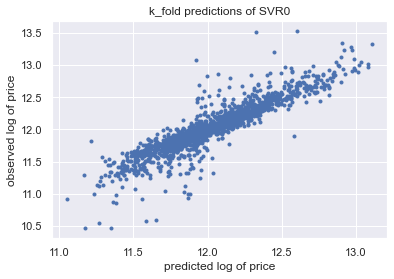

Nombre de composantes principales: 130
MSE : 0.027810058648496873
Root mean squared logarithmic error (Kaggle measure) : 0.16676216190611431


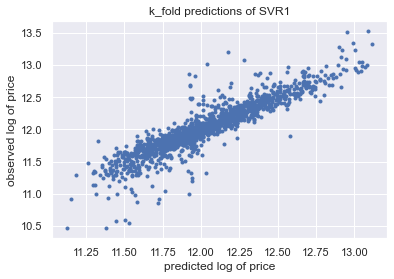

Nombre de composantes principales: 130
MSE : 0.030324880406630752
Root mean squared logarithmic error (Kaggle measure) : 0.17413902067288714


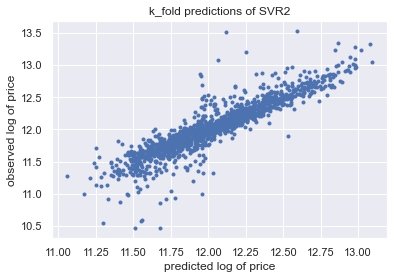

 
 ====== Ridge ====== 

Nombre de composantes principales: 130
MSE : 0.013296775633243203
Root mean squared logarithmic error (Kaggle measure) : 0.1153106865497298


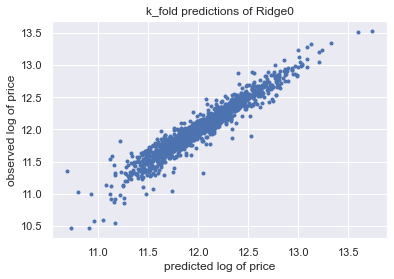

Nombre de composantes principales: 130
MSE : 0.013322981023741994
Root mean squared logarithmic error (Kaggle measure) : 0.11542422581501448


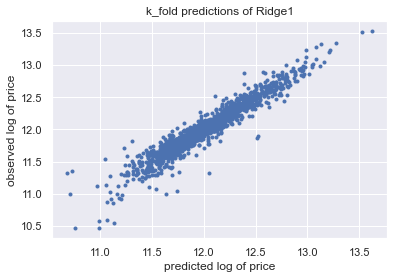

Nombre de composantes principales: 130
MSE : 0.012922102815822307
Root mean squared logarithmic error (Kaggle measure) : 0.11367447030354567


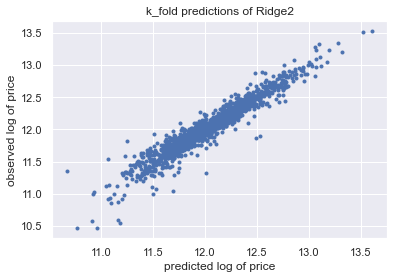

 
 ====== Lasso ====== 

Nombre de composantes principales: 130
MSE : 0.04370310175374656
Root mean squared logarithmic error (Kaggle measure) : 0.20905137126441883


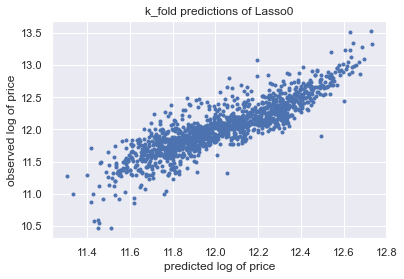

Nombre de composantes principales: 130
MSE : 0.04211793120465949
Root mean squared logarithmic error (Kaggle measure) : 0.20522504188135698


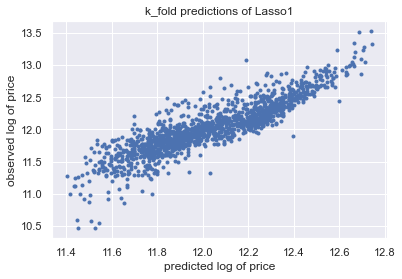

Nombre de composantes principales: 130
MSE : 0.045101365830800724
Root mean squared logarithmic error (Kaggle measure) : 0.21236932458670293


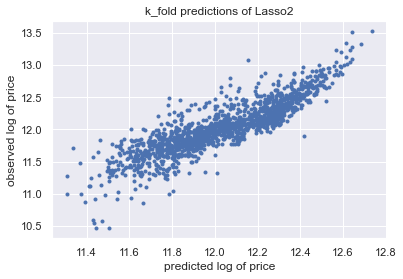

 
 ====== Tree ====== 

Nombre de composantes principales: 130
MSE : 0.04593863537168926
Root mean squared logarithmic error (Kaggle measure) : 0.21433123270542478


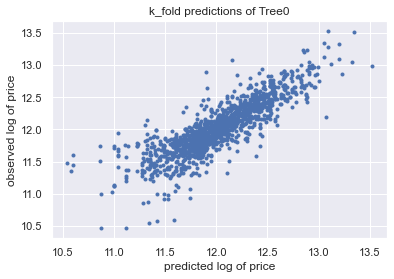

Nombre de composantes principales: 130
MSE : 0.04455318847873884
Root mean squared logarithmic error (Kaggle measure) : 0.21107466167650182


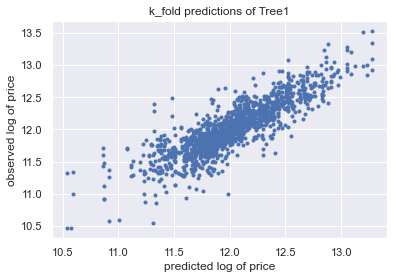

Nombre de composantes principales: 130
MSE : 0.04489698978053311
Root mean squared logarithmic error (Kaggle measure) : 0.21188734332647144


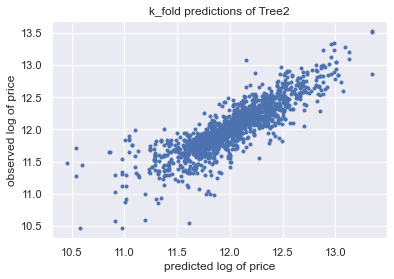

 
 ====== Bayes ====== 

Nombre de composantes principales: 130
MSE : 0.013493849023117774
Root mean squared logarithmic error (Kaggle measure) : 0.11616204041599541


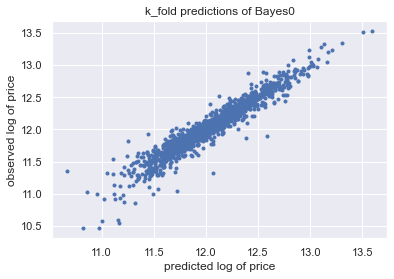

Nombre de composantes principales: 130
MSE : 0.012956316080122446
Root mean squared logarithmic error (Kaggle measure) : 0.11382485658488704


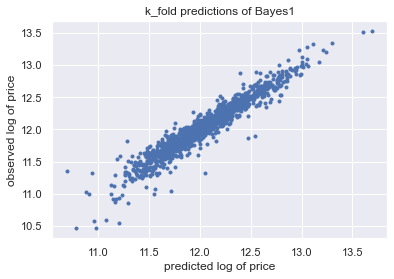

Nombre de composantes principales: 130
MSE : 0.013392984374247083
Root mean squared logarithmic error (Kaggle measure) : 0.11572710274270083


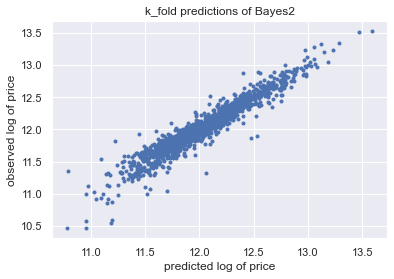

 
 ====== KNeighbors ====== 

Nombre de composantes principales: 130
MSE : 0.03405977034326338
Root mean squared logarithmic error (Kaggle measure) : 0.18455154531478737


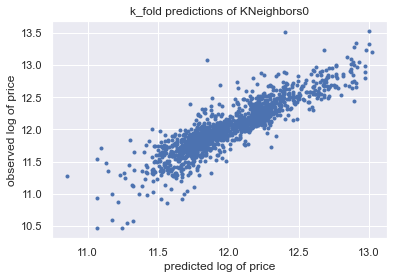

Nombre de composantes principales: 130
MSE : 0.03386386013742083
Root mean squared logarithmic error (Kaggle measure) : 0.18402003568594882


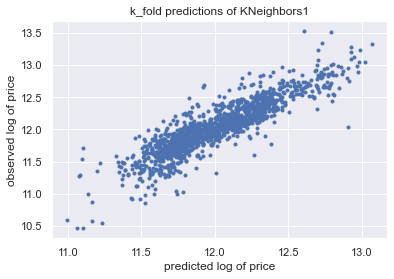

Nombre de composantes principales: 130
MSE : 0.03706128090444717
Root mean squared logarithmic error (Kaggle measure) : 0.19251162713794995


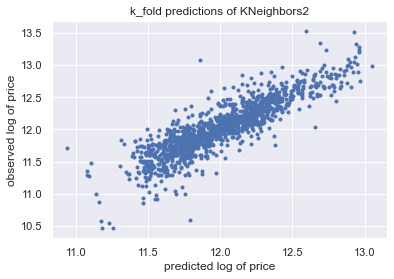

 
 ====== ElasticNet ====== 

Nombre de composantes principales: 130
MSE : 0.05764854400528973
Root mean squared logarithmic error (Kaggle measure) : 0.2400994412355995


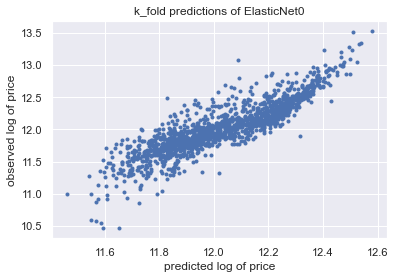

Nombre de composantes principales: 130
MSE : 0.058260717006328955
Root mean squared logarithmic error (Kaggle measure) : 0.24137088379141006


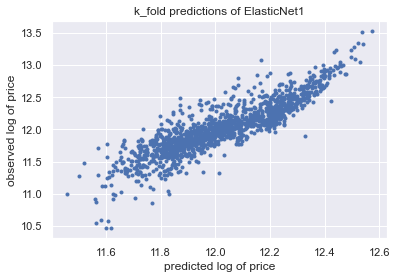

Nombre de composantes principales: 130
MSE : 0.05831040667480376
Root mean squared logarithmic error (Kaggle measure) : 0.24147378216140786


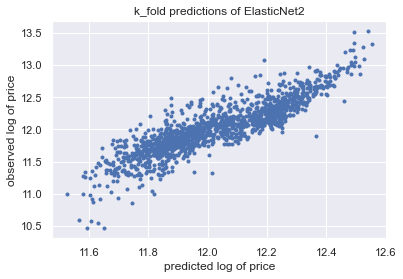

 
 ====== ForestMse ====== 

 
 ====== ENetRobust ====== 

Nombre de composantes principales: 130
MSE : 0.016985394464301508
Root mean squared logarithmic error (Kaggle measure) : 0.13032706936444804


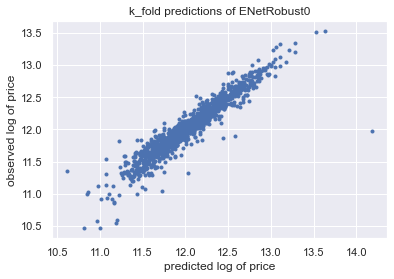

Nombre de composantes principales: 130
MSE : 0.013594685655896879
Root mean squared logarithmic error (Kaggle measure) : 0.11659527084865509


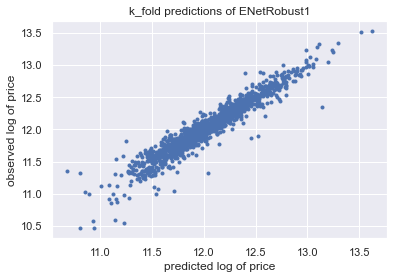

Nombre de composantes principales: 130
MSE : 0.014005112581346119
Root mean squared logarithmic error (Kaggle measure) : 0.11834220575676398


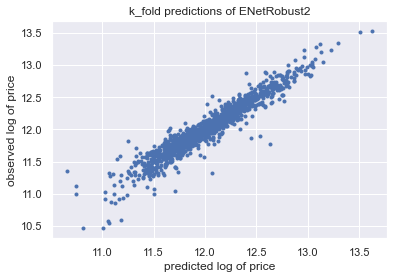

 
 ====== RidgeRobust ====== 

Nombre de composantes principales: 130
MSE : 0.016041360198977537
Root mean squared logarithmic error (Kaggle measure) : 0.12665346097764957


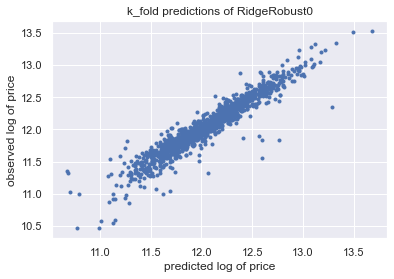

Nombre de composantes principales: 130
MSE : 0.02173474318843336
Root mean squared logarithmic error (Kaggle measure) : 0.14742600611462076


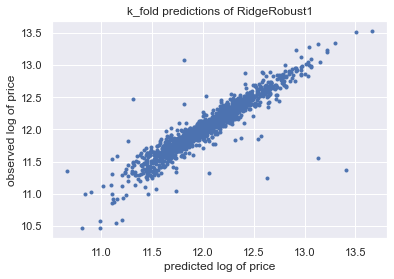

Nombre de composantes principales: 130
MSE : 0.09950680499279935
Root mean squared logarithmic error (Kaggle measure) : 0.3154461866184136


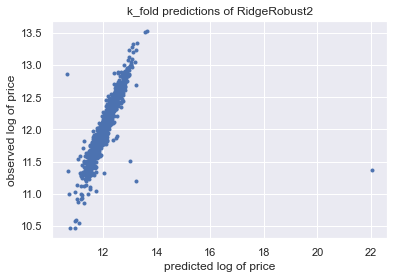

 
 ====== LassoRobust ====== 

Nombre de composantes principales: 130
MSE : 0.01357462382654407
Root mean squared logarithmic error (Kaggle measure) : 0.11650920857713765


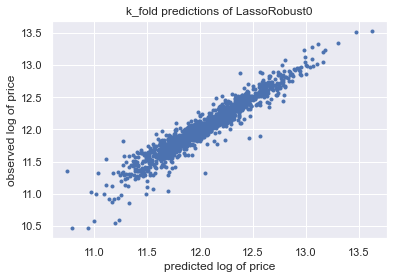

Nombre de composantes principales: 130
MSE : 0.014095953186840392
Root mean squared logarithmic error (Kaggle measure) : 0.11872538109565789


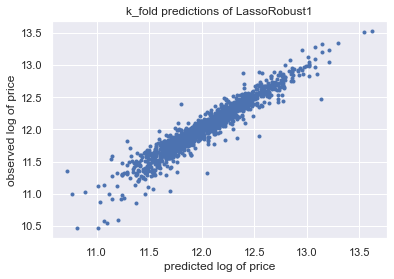

Nombre de composantes principales: 130
MSE : 0.013425102407141187
Root mean squared logarithmic error (Kaggle measure) : 0.11586576462444442


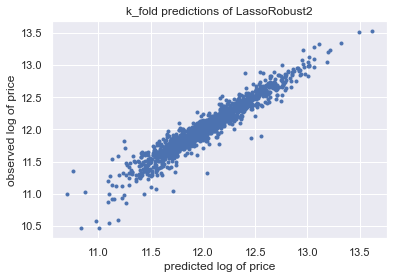

 
 ====== GBoostRobust ====== 

 
 ====== XGBRobust ====== 

 
 ====== LGBRobust ====== 



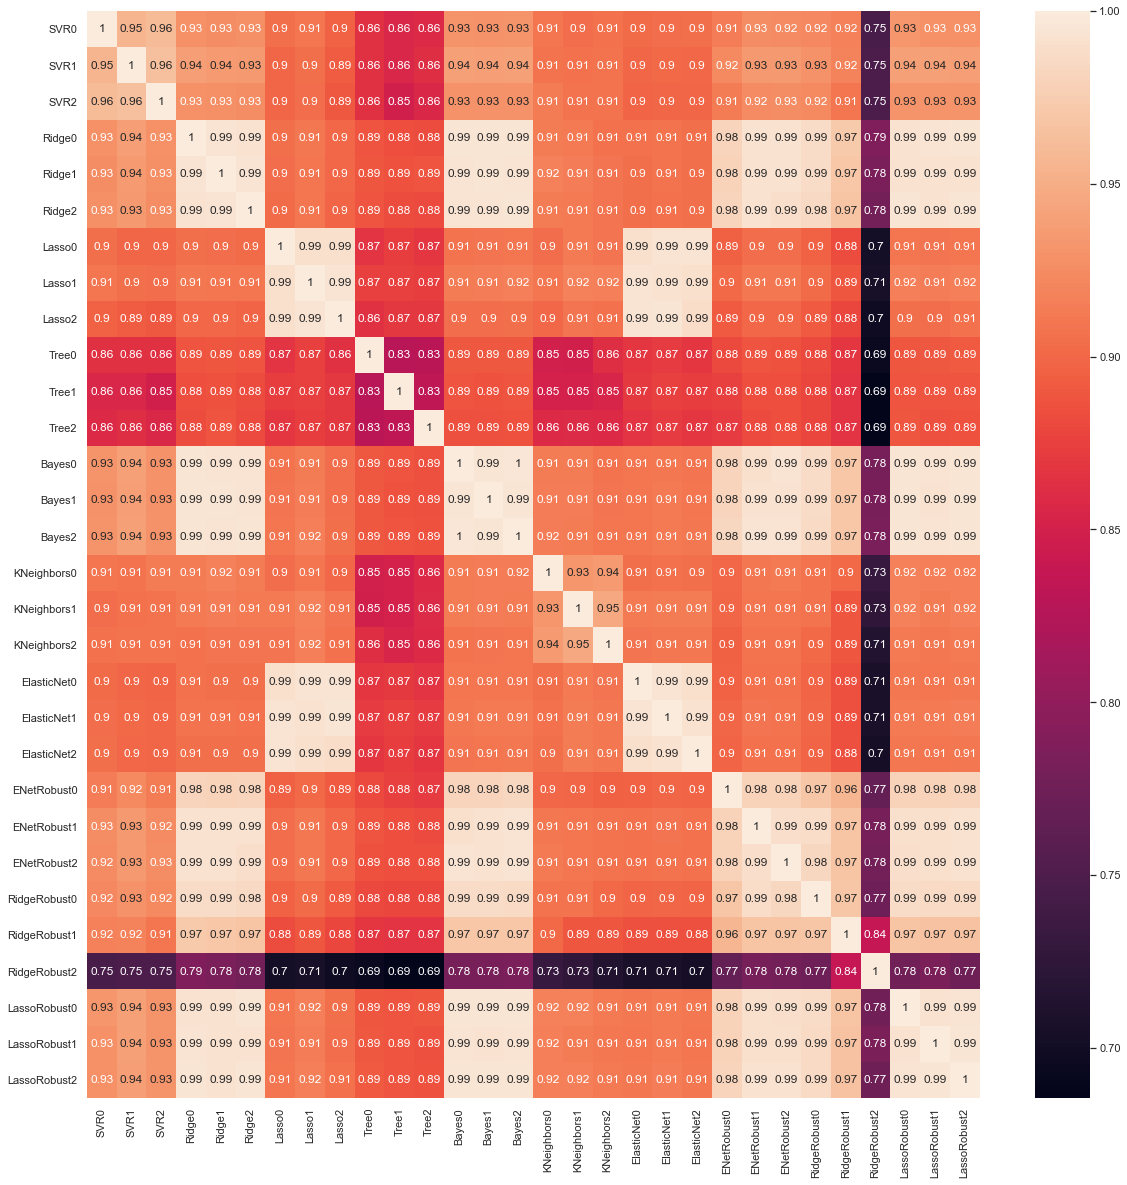

C:\Users\HP\miniconda3\envs\maisons\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\Users\HP\miniconda3\envs\maisons\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


Nombre de composantes principales: 30
MSE : 0.01250206908060414
Root mean squared logarithmic error (Kaggle measure) : 0.11181169840145078


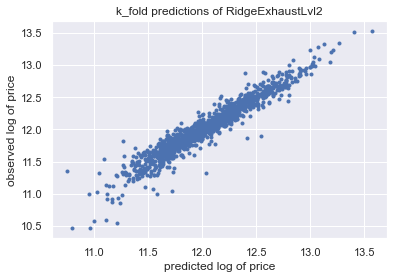

In [384]:
models = dict()
trainEnsemble = pd.DataFrame()
testEnsemble = pd.DataFrame()

# === LEVEL 1 === #
"""
for i, (key, value) in enumerate(BASIC.items()):
    print(f' \n ====== {key} ====== \n')
    model = Model(key, value['model'], value['params'])
    model.run()

if FANCY_MODELS:
    for i, (key, value) in enumerate(FANCY.items()):
        print(f' \n ====== {key} ====== \n')
        model = Model(key, value['model'], value['params'])
        model.run()
"""
for i, (key, value) in enumerate(ALL_MODELS.items()):
    print(f' \n ====== {key} ====== \n')
    model = Model(key, value['model'], value['params'])
    model.run()
    
trainEnsemble.to_csv('trainEnsemble2.csv')
testEnsemble.to_csv('testEnsemble2.csv')

pred_train = pd.read_csv('trainEnsemble2.csv').drop(['Unnamed: 0'], axis=1)
pred_test = pd.read_csv('testEnsemble2.csv').drop(['Unnamed: 0'], axis=1)

var_nb_lvl2 = pred_train.shape[1]


corrMatrix = pred_train.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corrMatrix, annot=True)
plt.show()
sns.set(rc={'figure.figsize':(6,4)})

pred_test_mean = pred_test.mean(axis=1)
produce_submission(np.exp(pred_test_mean), 'M_mean')

# === LEVEL 2 === #

column_selection = [col for col in pred_train.columns if models[col]['Kaggle_measure'] < 0.3]
total_weights = np.sum(1/models[col]['Kaggle_measure'] for col in column_selection)
pred_test_mean_weighted = np.sum(models[col]['y_test_predict']/models[col]['Kaggle_measure'] for col in column_selection)
pred_test_mean_weighted/=total_weights
produce_submission(np.exp(pred_test_mean_weighted), 'M_mean_weighted')

# Sélection des variables explicatives
debut, fin = 0, var_nb_lvl2
column_selection = pred_train.columns[debut:fin]
train_X, test_X = pred_train[column_selection], pred_test[column_selection]

# Sélection d'hyperParamètres
best_alpha = 20

# Sélection du nombre de composantes principales
pc_nb =  var_nb_lvl2
print(f'Nombre de composantes principales: {pc_nb}')
new_train_X, new_test_X = pca_function(train_X, test_X, pc_nb)

# On construit le modèle et on fait les prédictions
make_predictions('RidgeExhaustLvl2', Ridge(alpha = best_alpha), new_train_X, new_test_X, y)

produce_submission(np.exp(models['RidgeExhaustLvl2']['y_test_predict']), 'M_Ridge')

## Sélection des variables explicatives (on ne prend que les modèles qui ont une bonne mesure de perforamance
## lors de la validation croisée)
#column_selection = [col for col in pred_train.columns if models[col]['Kaggle_measure'] < 2.0]
#train_X, test_X = pred_train[column_selection], pred_test[column_selection]

## Sélection d'hyperParamètres
#best_alpha = 2

## Sélection du nombre de composantes principales
#pc_nb =  10
#print(f'Nombre de composantes principales: {pc_nb}')
#new_train_X, new_test_X = pca_function(train_X, test_X, pc_nb)

## On construit le modèle et on fait les prédictions
#make_predictions('RidgeExhaustLvl2_pc10', Ridge(alpha = best_alpha), new_train_X, new_test_X, y)

#produce_submission(np.exp(models['RidgeExhaustLvl2_pc10']['y_test_predict']), 'M_Ridge_pc10')

# Constants and global variables

In [379]:
N_FOLDS = 20 # 1460 = 20 * 73 observations d'entraînement
j = 60
k = 70
MODEL_NB = 3
MODEL_NBS = {
    'SVR': {'model_nb': MODEL_NB},
    'Ridge': {'model_nb': MODEL_NB},
    'Lasso': {'model_nb': MODEL_NB},
    'Tree': {'model_nb': MODEL_NB},
    'Bayes': {'model_nb': MODEL_NB},
    'KNeighbors': {'model_nb': MODEL_NB},
    'ElasticNet': {'model_nb': MODEL_NB},
    'ForestMse': {'model_nb': 0},
    'ENetRobust': {'model_nb': MODEL_NB},
    'RidgeRobust': {'model_nb': MODEL_NB},
    'LassoRobust': {'model_nb': MODEL_NB},
    'GBoostRobust': {'model_nb': 0},
    'XGBRobust': {'model_nb': 0},
    'LGBRobust': {'model_nb': 0}
}
HYPER_TUNING = 0
PC_CONVEX = 0
PC_EXHAUST = [] # PC_EXHAUST test parmis ces nombres de composantes principales
FANCY_MODELS = 0

# Sélection de modèles (backward/forward)

## Entraînement des modèles avec les paramètres choisis

 
 ====== SVR ====== 

Nombre de composantes principales: 35
MSE : 0.031092247478039674
Root mean squared logarithmic error (Kaggle measure) : 0.17632854359768377


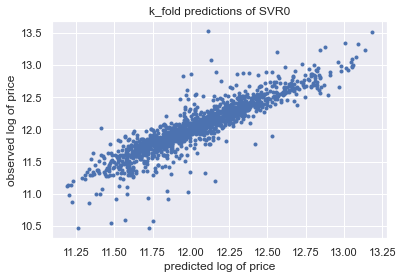

Nombre de composantes principales: 35
MSE : 0.03276607511775297
Root mean squared logarithmic error (Kaggle measure) : 0.18101257611117533


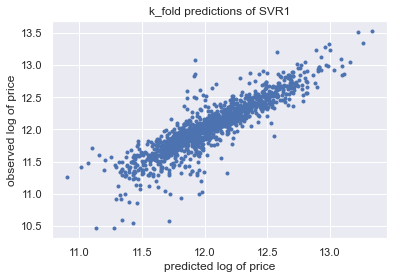

 
 ====== Ridge ====== 

Nombre de composantes principales: 35
MSE : 0.022555921427534965
Root mean squared logarithmic error (Kaggle measure) : 0.15018511130247938


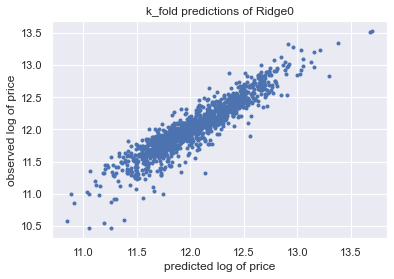

Nombre de composantes principales: 35
MSE : 0.02298022034933779
Root mean squared logarithmic error (Kaggle measure) : 0.15159107590941942


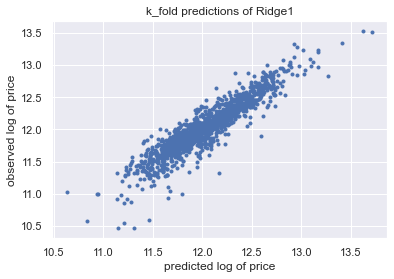

 
 ====== Lasso ====== 

Nombre de composantes principales: 35
MSE : 0.10948336175328345
Root mean squared logarithmic error (Kaggle measure) : 0.3308804971463895


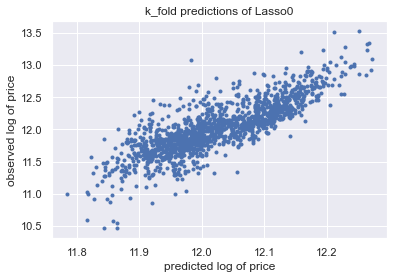

Nombre de composantes principales: 35
MSE : 0.092704393063735
Root mean squared logarithmic error (Kaggle measure) : 0.30447190133510177


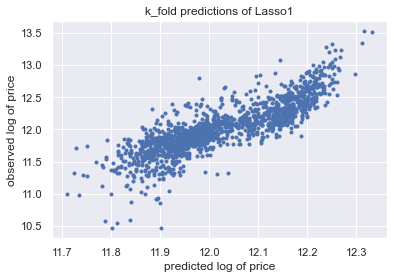

 
 ====== Tree ====== 

Nombre de composantes principales: 35
MSE : 0.05193138447048868
Root mean squared logarithmic error (Kaggle measure) : 0.2278829017941845


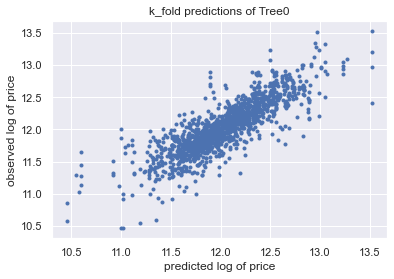

Nombre de composantes principales: 35
MSE : 0.0448413592282221
Root mean squared logarithmic error (Kaggle measure) : 0.21175618406655491


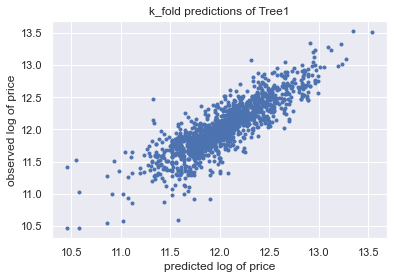

 
 ====== Bayes ====== 

Nombre de composantes principales: 35
MSE : 0.02160760729669507
Root mean squared logarithmic error (Kaggle measure) : 0.14699411429461345


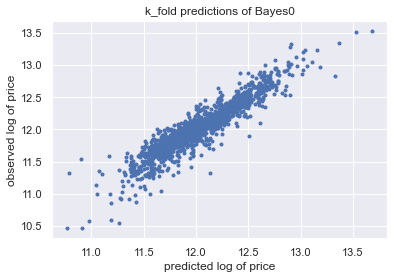

Nombre de composantes principales: 35
MSE : 0.021781526945114017
Root mean squared logarithmic error (Kaggle measure) : 0.14758441330505115


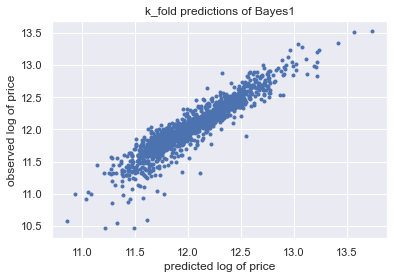

 
 ====== KNeighbors ====== 

Nombre de composantes principales: 35
MSE : 0.041564366621041
Root mean squared logarithmic error (Kaggle measure) : 0.2038718638428968


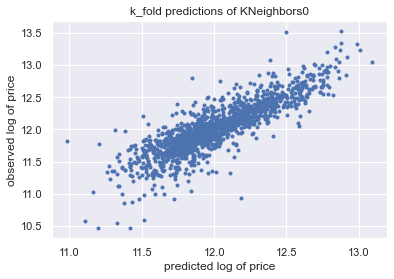

Nombre de composantes principales: 35
MSE : 0.03822424299173227
Root mean squared logarithmic error (Kaggle measure) : 0.1955087461873537


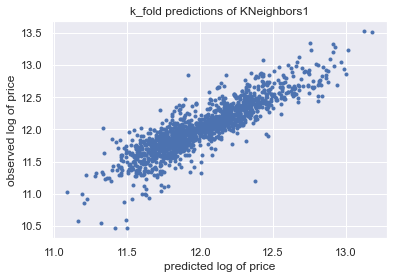

 
 ====== ElasticNet ====== 

Nombre de composantes principales: 35
MSE : 0.11574703357230677
Root mean squared logarithmic error (Kaggle measure) : 0.3402139111120359


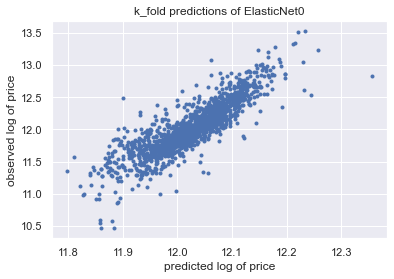

Nombre de composantes principales: 35
MSE : 0.1024826070226506
Root mean squared logarithmic error (Kaggle measure) : 0.3201268962041373


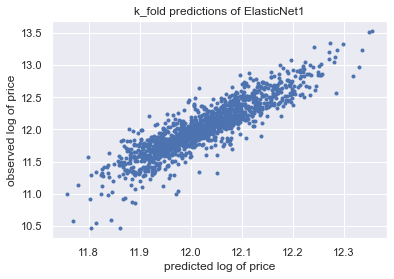

 
 ====== ForestMse ====== 

 
 ====== ENetRobust ====== 

Nombre de composantes principales: 35
MSE : 0.019581730725462165
Root mean squared logarithmic error (Kaggle measure) : 0.13993354558992274


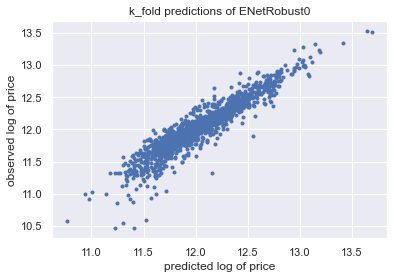

Nombre de composantes principales: 35
MSE : 0.018057475480138772
Root mean squared logarithmic error (Kaggle measure) : 0.13437704989201946


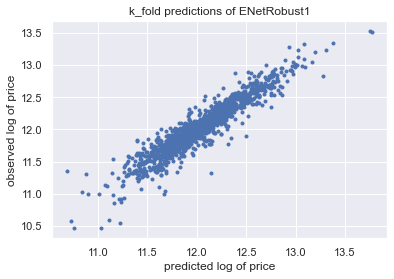

 
 ====== RidgeRobust ====== 

Nombre de composantes principales: 35
MSE : 0.2625357508027346
Root mean squared logarithmic error (Kaggle measure) : 0.5077902200971051


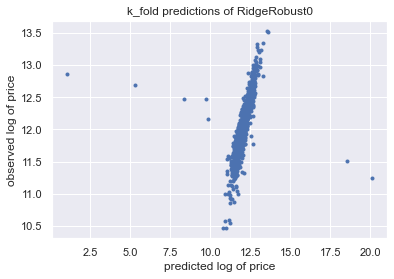

Nombre de composantes principales: 35
MSE : 0.02113834378036947
Root mean squared logarithmic error (Kaggle measure) : 0.1453891797195363


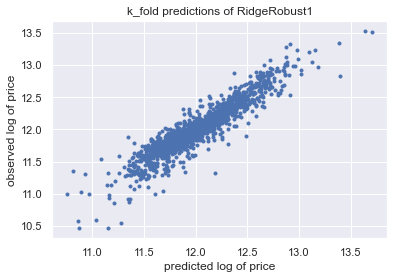

 
 ====== LassoRobust ====== 

Nombre de composantes principales: 35
MSE : 0.02097098564748693
Root mean squared logarithmic error (Kaggle measure) : 0.1448124378187248


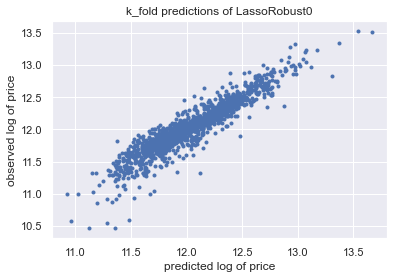

Nombre de composantes principales: 35
MSE : 0.025806432274604506
Root mean squared logarithmic error (Kaggle measure) : 0.16064260364707594


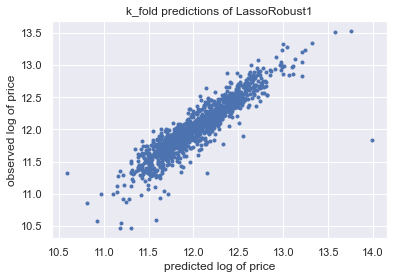

 
 ====== GBoostRobust ====== 

 
 ====== XGBRobust ====== 

 
 ====== LGBRobust ====== 



In [412]:
N_FOLDS = 20 # 1460 = 20 * 73 observations d'entraînement
j = 5
k = 30
MODEL_NB = 2
HYPER_TUNING = 0
PC_CONVEX = 0
PC_EXHAUST = [] # PC_EXHAUST test parmis ces nombres de composantes principales
FANCY_MODELS = 0
MODEL_NBS = {
    'SVR': {'model_nb': MODEL_NB},
    'Ridge': {'model_nb': MODEL_NB},
    'Lasso': {'model_nb': MODEL_NB},
    'Tree': {'model_nb': MODEL_NB},
    'Bayes': {'model_nb': MODEL_NB},
    'KNeighbors': {'model_nb': MODEL_NB},
    'ElasticNet': {'model_nb': MODEL_NB},
    'ForestMse': {'model_nb': 0},
    'ENetRobust': {'model_nb': MODEL_NB},
    'RidgeRobust': {'model_nb': MODEL_NB},
    'LassoRobust': {'model_nb': MODEL_NB}, 
    'GBoostRobust': {'model_nb': 0},
    'XGBRobust': {'model_nb': 0},
    'LGBRobust': {'model_nb': 0}
}

models = dict()
trainEnsemble = pd.DataFrame()
testEnsemble = pd.DataFrame()

for i, (key, value) in enumerate(ALL_MODELS.items()):
    print(f' \n ====== {key} ====== \n')
    model = Model(key, value['model'], value['params'])
    model.run()
    
trainEnsemble.to_csv('trainEnsemble2.csv')
testEnsemble.to_csv('testEnsemble2.csv')

pred_train = pd.read_csv('trainEnsemble2.csv').drop(['Unnamed: 0'], axis=1)
pred_test = pd.read_csv('testEnsemble2.csv').drop(['Unnamed: 0'], axis=1)

## Code pour faire la sélection de modèles (manuellement), avec Ridge comme référent de 2e niveau

Nombre de composantes principales: 14
MSE : 0.016109391328899225
Root mean squared logarithmic error (Kaggle measure) : 0.1269217312406669


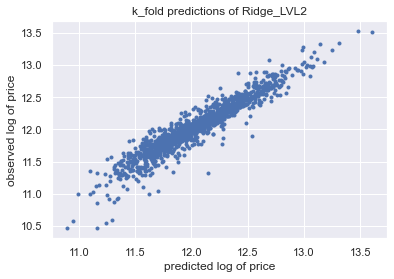

In [413]:
use_SVR         = 1 ###
use_Ridge       = 1 ###
use_Lasso       = 1 ###
use_Tree        = 1 ###
use_Bayes       = 1 ###
use_KNeighbors  = 0
use_ElasticNet  = 1 ###
use_ENetRobust  = 1 ###
use_RidgeRobust = 0
use_LassoRobust = 0

column_selection = pred_train.columns[0:0]
if(use_SVR):
    column_selection = column_selection.union(pred_train.columns[0:MODEL_NB])        
if(use_Ridge):
    column_selection = column_selection.union(pred_train.columns[MODEL_NB :2*MODEL_NB])      
if(use_Lasso):
    column_selection = column_selection.union(pred_train.columns[2*MODEL_NB:3*MODEL_NB])      
if(use_Tree):
    column_selection = column_selection.union(pred_train.columns[3*MODEL_NB:4*MODEL_NB])       
if(use_Bayes):
    column_selection = column_selection.union(pred_train.columns[4*MODEL_NB:5*MODEL_NB])      
if(use_KNeighbors):
    column_selection = column_selection.union(pred_train.columns[5*MODEL_NB:6*MODEL_NB]) 
if(use_ElasticNet):
    column_selection = column_selection.union(pred_train.columns[6*MODEL_NB:7*MODEL_NB]) 
if(use_ENetRobust):
    column_selection = column_selection.union(pred_train.columns[7*MODEL_NB:8*MODEL_NB]) 
if(use_RidgeRobust):
    column_selection = column_selection.union(pred_train.columns[8*MODEL_NB:9*MODEL_NB])
if(use_LassoRobust):
    column_selection = column_selection.union(pred_train.columns[9*MODEL_NB:10*MODEL_NB])
    
train_X, test_X = pred_train[column_selection], pred_test[column_selection]

# === LEVEL 2 === #
# Sélection d'hyperParamètres
best_alpha = 20

# Sélection du nombre de composantes principales
pc_nb =  column_selection.size
print(f'Nombre de composantes principales: {pc_nb}')
new_train_X, new_test_X = pca_function(train_X, test_X, pc_nb)

# On construit le modèle et on fait les prédictions
make_predictions('Ridge_LVL2', Ridge(alpha = best_alpha), new_train_X, new_test_X, y)

## Comparaison des modèles de 2e niveau

MSE : 0.017102382947617147
Root mean squared logarithmic error (Kaggle measure) : 0.13077503986469044


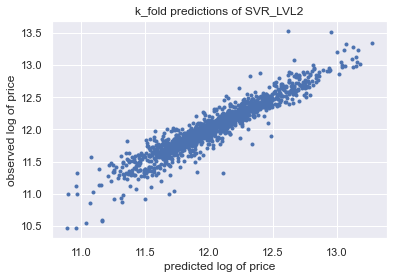

MSE : 0.016043157525623495
Root mean squared logarithmic error (Kaggle measure) : 0.12666054439175248


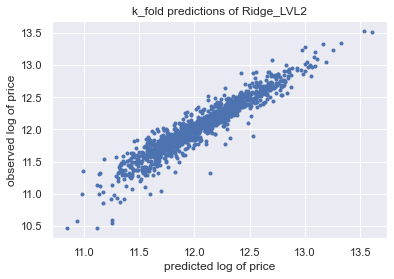

MSE : 0.10036897935496213
Root mean squared logarithmic error (Kaggle measure) : 0.3168085053083593


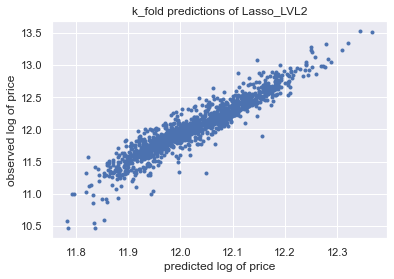

MSE : 0.03224077177008119
Root mean squared logarithmic error (Kaggle measure) : 0.17955575479368946


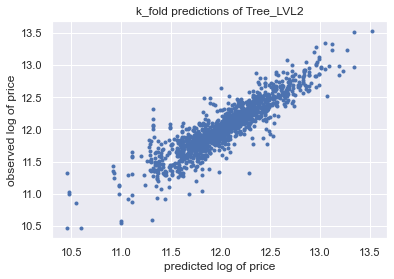

MSE : 0.016036733853001004
Root mean squared logarithmic error (Kaggle measure) : 0.12663518414541106


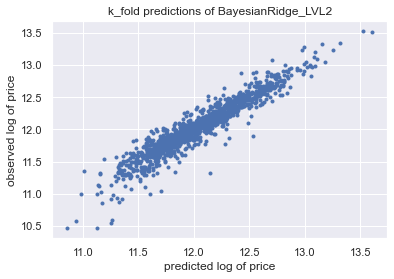

MSE : 0.01990145532905849
Root mean squared logarithmic error (Kaggle measure) : 0.1410713622829903


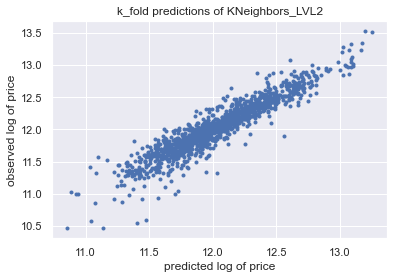

MSE : 0.04175509830733344
Root mean squared logarithmic error (Kaggle measure) : 0.20433911984454345


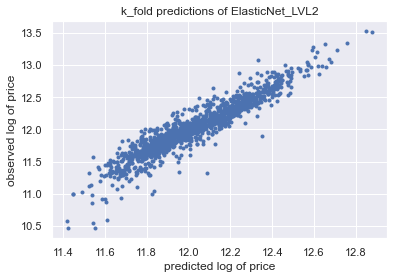

MSE : 0.016048903330425995
Root mean squared logarithmic error (Kaggle measure) : 0.12668322307360969


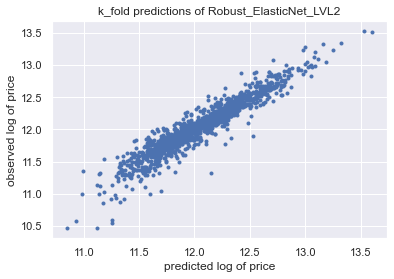

MSE : 0.016053267420402265
Root mean squared logarithmic error (Kaggle measure) : 0.1267004456586533


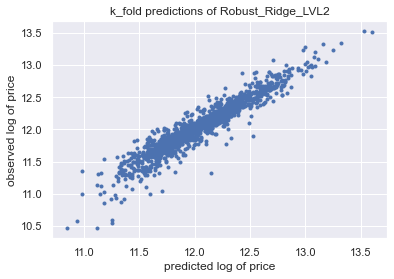

MSE : 0.01604548927908061
Root mean squared logarithmic error (Kaggle measure) : 0.12666974613628146


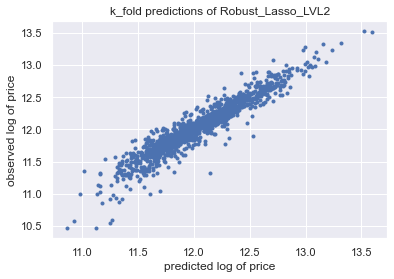

In [436]:
make_predictions('SVR_LVL2', SVR() , new_train_X, new_test_X, y)
make_predictions('Ridge_LVL2', Ridge() , new_train_X, new_test_X, y)
make_predictions('Lasso_LVL2', Lasso() , new_train_X, new_test_X, y)
make_predictions('Tree_LVL2', tree.DecisionTreeRegressor() , new_train_X, new_test_X, y)
make_predictions('BayesianRidge_LVL2', linear_model.BayesianRidge() , new_train_X, new_test_X, y)
make_predictions('KNeighbors_LVL2', KNeighborsRegressor() , new_train_X, new_test_X, y)
make_predictions('ElasticNet_LVL2', ElasticNet() , new_train_X, new_test_X, y)
make_predictions('Robust_ElasticNet_LVL2', make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.5, random_state=431)) , new_train_X, new_test_X, y)
make_predictions('Robust_Ridge_LVL2', make_pipeline(RobustScaler(), Ridge(alpha=2)) , new_train_X, new_test_X, y)
make_predictions('Robust_Lasso_LVL2', make_pipeline(RobustScaler(), Lasso(alpha=0.001)) , new_train_X, new_test_X, y)

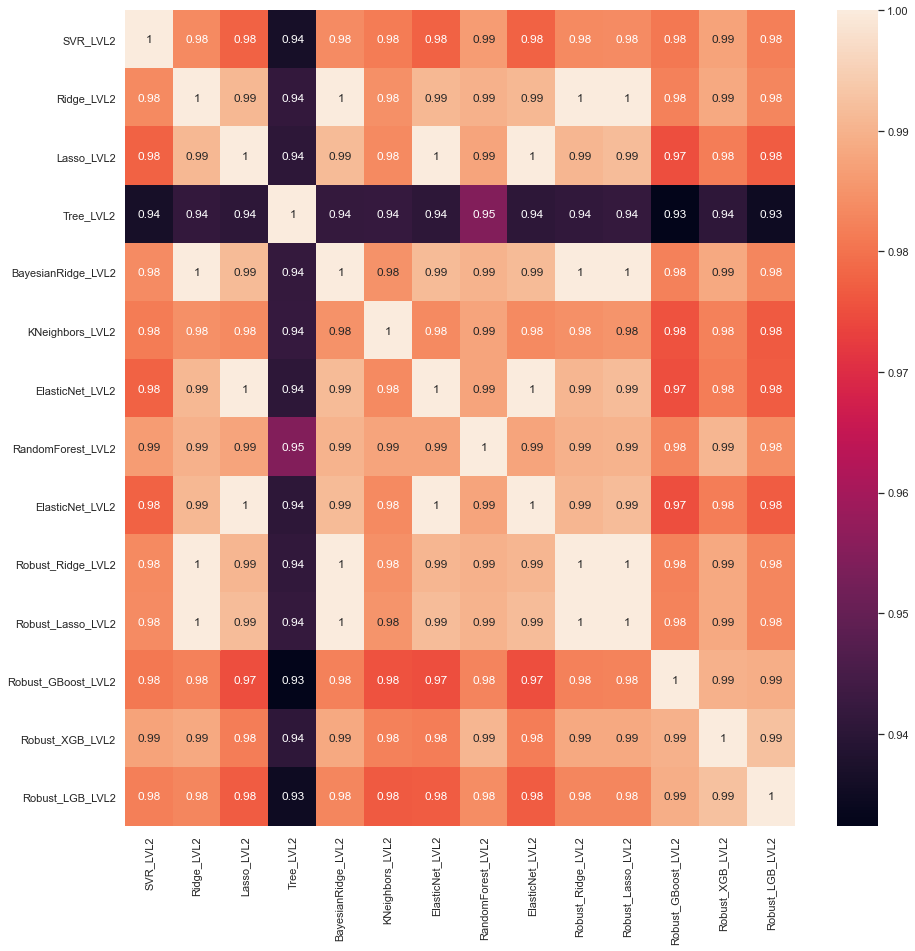

In [454]:
models_LVL2 = ['SVR_LVL2', 'Ridge_LVL2', 'Lasso_LVL2', 'Tree_LVL2', 'BayesianRidge_LVL2', 'KNeighbors_LVL2', 'ElasticNet_LVL2', 'RandomForest_LVL2', 'ElasticNet_LVL2', 'Robust_Ridge_LVL2', 'Robust_Lasso_LVL2', 'Robust_GBoost_LVL2', 'Robust_XGB_LVL2', 'Robust_LGB_LVL2']

#Prédictions de 2e niveau
trainEnsembleLVL2 = trainEnsemble[models_LVL2]
testEnsembleLVL2  = testEnsemble[models_LVL2]

#Matrice de corrélation des prédictions de 2e niveau
corrMatrix = testEnsembleLVL2.corr()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(corrMatrix, annot=True)
plt.show()
sns.set(rc={'figure.figsize':(6,4)})

# Autres modèles ensemblistes

MSE : 0.013151838266883095
Root mean squared logarithmic error (Kaggle measure) : 0.11468051208745401


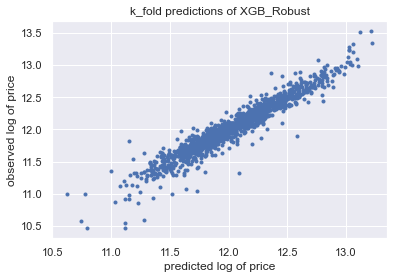

In [445]:
### Celui-ci est nettement meilleur que tous les autres modèles ensemblistes testés ###
make_predictions('XGB_Robust', make_pipeline(RobustScaler(), XGB), train, test, y)

## Combinaison des prédicitons de 2e niveau choisies et des autres modèles ensemblistes

In [451]:
final_models = ['Ridge_LVL2', 'XGB_Robust']

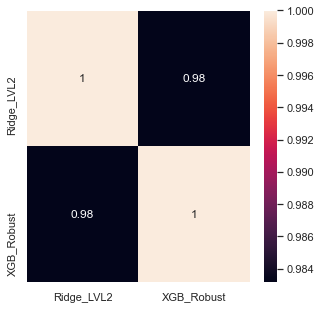

In [453]:
testEnsembleLVL2  = testEnsemble[final_models]

#Matrice de corrélation des prédictions des modèles finaux
corrMatrix = testEnsembleLVL2.corr()
sns.set(rc={'figure.figsize':(5,5)})
sns.heatmap(corrMatrix, annot=True)
plt.show()
sns.set(rc={'figure.figsize':(6,4)})

In [446]:
n_tests = models[final_models[0]]['y_test_predict'].size
mean_preds = np.zeros(n_tests)
for mod in final_models:
    preds_mod    = models[mod]['y_test_predict']
    mean_preds = mean_preds+preds_mod
    
mean_preds=mean_preds/len(final_models)

produce_submission(np.exp(preds_XGBRobust), 'preds_XGBRobust ')
produce_submission(np.exp(mean_preds), 'preds_XGBRobust_Ridge_LVL2 ')